# OCCLUSION MAPS

## Goals
- Compute  occlusion maps for each lesion.

## Methodology
*(See Mid-Term presentation for visual explanation)*
1. Get a lesion predicted as a rim positive to see what is the most important pixels for the network to say "RIM+".
2. Iterate through the image, hiding a white cube of 2x2x2 each time in a different position.
3. For each different position, predict the rim value.
4. In the end, you will have a matrix of half the size of the original patch. Substract each prediction from 1 to get white in the pixels that the prediction is lower (that will mean that without that pixel, the network can't predict that good RIM+.
5. Upsample it to lesion size and compare.

## Compatibility
- **Only** with 1 channel data.

In [1]:
import archs.cnn_2 as cnn2
import archs.cnn_3 as cnn3
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
from config import *
import time
import os
from tqdm import tqdm
import tensorflow.contrib.slim as slim
import sys
from widgets import ImageSliceViewer3D,OcclusionMapViewer3D
from scipy import ndimage
from utils import get_folds_indexes, get_lesion, process_patch, get_folded_data, generate_epoch_batches, compute_transformation, clean_data, copy_data








The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [92]:

def get_patient_fold(patient):
    testing_folds = [fold["testing"] for fold in get_folds_indexes()]
    
    num_fold = 0
    found = False
    while not found and num_fold < len(testing_folds):
        if patient in testing_folds[num_fold]:
            found = True
        else:
            num_fold += 1
    return num_fold

def get_rim_prediction(sess, patch):
    prediction, = sess.run([pred], feed_dict = {x: [patch]})
    return prediction[0][1]

def preprocess(image, i, j, k, value):
    size = 2
    image = image.copy()
    image[size*i:size*(i+1), size*j:size*(j+1), size*k:size*(k+1)] = value
    #image[i:i+size, j:j+size, k:k+size] = -1
    return image

def get_occlusion_map(sess, patch, value, original_pred):
    occlusion_map = [[[min(original_pred, get_rim_prediction(sess, preprocess(patch, i, j, k, value))) 
                           for k in range(patch.shape[2]//2)]
                          for j in range(patch.shape[1]//2)]
                         for i in range(patch.shape[0]//2)]

        #occlusion_map = [[[get_rim_prediction(sess, preprocess(image, i, j, k)) 
        #                   for k in range(image.shape[2]-1)]
        #                  for j in range(image.shape[1]-1)]
        #                 for i in range(image.shape[0]-1)]
    return np.array(occlusion_map)

def show_occlusion_map(sess, patch, value, original_pred, *, show_mask=True):
    occlusion_map = get_occlusion_map(sess, patch, value, original_pred)
    patch = patch.squeeze()

    occlusion_map_upsampled = ndimage.interpolation.zoom(occlusion_map, np.array(patch.shape)/np.array(occlusion_map.shape, dtype=np.float32), order=3, mode='nearest')
    occ = 1-occlusion_map_upsampled
    
    import matplotlib.pyplot as plt
    #fig, ax = plt.subplots(2, 1, figsize=(10, 10))
    #idx = np.where(occ == np.max(occ))[2][0]
    #print(idx)
    #ax[0].imshow(patch[:,:,idx], cmap='gray')
    #ax[1].imshow(occ[:,:,idx], cmap='gray', vmin=1-original_pred, vmax=1)
    return patch, occ
    #fig.colorbar(cm.ScalarMappable(norm=None, cmap='gray'), ax=ax[1])#OrRd
    #OcclusionMapViewer3D(patch, patch, occ, show_mask=False)
    

In [85]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"
batch_size = 64
patch_size = width, height, depth = [28, 28, 28]

# NETWORK DATA
net = "phase"
if net == "phase":
    name = "02_unet_PHASE_FINAL"
    num_epochs = [20, 8, 3, 7, 7]
    cnn = cnn2
    contrasts = [PHASE]
    normalization = 'local_max'
    neutral = -1
elif net == "phase2":
    name = "02_unet_NCV_DA3_DEF"
    num_epochs = [16, 17, 14, 13, 14]
    cnn = cnn2
    contrasts = [PHASE]
    normalization = 'local_max'
    neutral = -1
elif net == "phase3":
    name = "02_unet_NCV_DA3"
    num_epochs = [18, 30, 24, 19, 22]
    cnn = cnn2
    contrasts = [PHASE]
    normalization = 'local_max'
    neutral = -1
elif net == "flair":
    name = "02_unet_FLAIR_FINAL"
    num_epochs = [9, 6, 10, 2, 5]
    cnn = cnn2
    contrasts = [FLAIR]
    normalization = 'local_max'
    neutral = 0
elif net == "eflair":
    name = "02_unet_FLAIR_DEF_TR"
    num_epochs = [8, 8, 6, 6, 6]
    cnn = cnn2
    contrasts = [FLAIR_MASKED]
    normalization = 'local_max'
    neutral = 0
elif net == "t2":
    name = "02_unet_T2_FINAL"
    num_epochs = [18, 7, 4, 11, 7]
    cnn = cnn2
    contrasts = [T2]
    normalization = 'local_max'
    neutral = -1


In [81]:


#for (pat, les) in ((10, 1001),(13, 1002),(13, 1003),(51, 1011),(29, 1005),(39, 1014),(39,1018),(37, 1006)): #TP
for (pat, les) in ((64, 2072), (43, 2024), (34,2013)): #FP
    lesion = get_lesion(pat, les)
    patch = process_patch(lesion, contrasts, normalization, patch_size)
    
    num_fold = get_patient_fold(pat)
    print(num_fold)
    PATH_TESTING = os.path.join(ROOT_DIR, os.path.join("checkpoints", name))
    FILENAME = f"check-{num_epochs[num_fold]}"
    path_testing = os.path.join(os.path.join(PATH_TESTING, str(num_fold)), FILENAME)

    tf.reset_default_graph()
    g = tf.Graph()
    with g.as_default():
        x, _, _, _, _, _, pred = cnn.get_model_graph(patch_size)

        def model_summary():
            model_vars = tf.trainable_variables()
            slim.model_analyzer.analyze_vars(model_vars, print_info=True)

        #model_summary()

    
    with tf.Session(graph=g) as sess:

        # Initialization
        init = tf.initializers.global_variables()

        sess.run(init)

        saver = tf.train.Saver(max_to_keep=50, keep_checkpoint_every_n_hours=1)
        saver.restore(sess, path_testing)
    
        confidence = get_rim_prediction(sess, patch)
        print(f"Prediction: {confidence}")
        
        print(f"{pat} - {les}")
        show_occlusion_map(sess, patch, neutral, confidence)
        
        import matplotlib.pyplot as plt
        plt.savefig(f'figs_occl/rim_neg/{pat}_{les}_{net}_{confidence:.2f}_v2.pdf', dpi = 400, format='pdf', bbox_inches='tight')
        plt.show()
    

2
INFO:tensorflow:Restoring parameters from /project/msrims/checkpoints/02_unet_PHASE_FINAL/2/check-3
Prediction: 0.7817150354385376
64 - 2072


KeyboardInterrupt: 

4
INFO:tensorflow:Restoring parameters from /project/msrims/checkpoints/02_unet_PHASE_FINAL/4/check-7
Prediction: 0.8608792424201965
13 - 1003


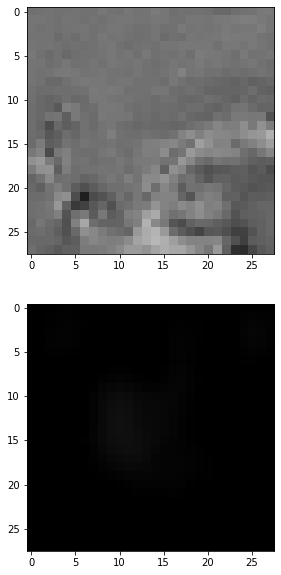

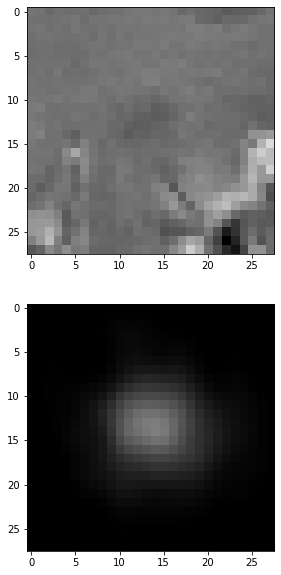

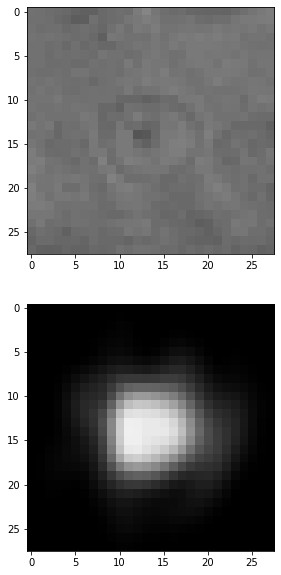

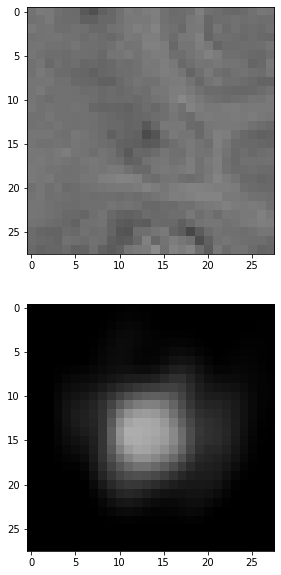

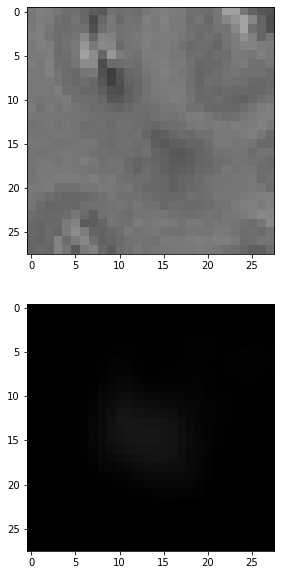

In [97]:
# SLICES

#for (pat, les) in ((10, 1001),(13, 1002),(13, 1003),(51, 1011),(29, 1005),(39, 1014),(39,1018),(37, 1006)): #TP
for (pat, les) in ((13, 1003),): #FP
    lesion = get_lesion(pat, les)
    patch = process_patch(lesion, contrasts, normalization, patch_size)
    
    num_fold = get_patient_fold(pat)
    print(num_fold)
    PATH_TESTING = os.path.join(ROOT_DIR, os.path.join("checkpoints", name))
    FILENAME = f"check-{num_epochs[num_fold]}"
    path_testing = os.path.join(os.path.join(PATH_TESTING, str(num_fold)), FILENAME)

    tf.reset_default_graph()
    g = tf.Graph()
    with g.as_default():
        x, _, _, _, _, _, pred = cnn.get_model_graph(patch_size)

        def model_summary():
            model_vars = tf.trainable_variables()
            slim.model_analyzer.analyze_vars(model_vars, print_info=True)

        #model_summary()

    
    with tf.Session(graph=g) as sess:

        # Initialization
        init = tf.initializers.global_variables()

        sess.run(init)

        saver = tf.train.Saver(max_to_keep=50, keep_checkpoint_every_n_hours=1)
        saver.restore(sess, path_testing)
    
        confidence = get_rim_prediction(sess, patch)
        print(f"Prediction: {confidence}")
        
        print(f"{pat} - {les}")
        patch, occ = show_occlusion_map(sess, patch, neutral, confidence)
        
        for idx in (4, 8, 13, 17, 22):
            import matplotlib.pyplot as plt
            fig, ax = plt.subplots(2, 1, figsize=(10, 10))
            ax[0].imshow(patch[:,:,idx], cmap='gray', vmin=-1, vmax=1)
            ax[1].imshow(occ[:,:,idx], cmap='gray', vmin=1-confidence, vmax=1)
            plt.savefig(f'figs_occl/slices/{pat}_{les}_{net}_{confidence:.2f}_{idx}.pdf', dpi = 400, format='pdf', bbox_inches='tight')
            plt.show()
    